Author: Doug Branton, Neven Caplar and the LINCC Frameworks team

Last updated: July 10, 2025

## Problem 2

Now, compute periodograms for ZTF DR22 lightcurves again, but this time only using photometry with no quality flags set in `catflags`.

In [4]:
import lsdb
from nested_pandas.utils import count_nested
from lsdb import ConeSearch

# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 0.2 * 3600  # Convert 0.2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

In [3]:
# Load ZTF DR22
ztf_ndf = lsdb.open_catalog('https://data.lsdb.io/hats/ztf_dr22/ztf_lc',
                            margin_cache='https://data.lsdb.io/hats/ztf_dr22/ztf_lc_10arcs',
                            search_filter=cones["Rubin_SV_95_-25"]).compute()

# The timeseries data in this dataset is stored as lists, we can convert these into a nested column
ztf_ndf = ztf_ndf.nest_lists(columns=["hmjd","mag","magerr","clrcoeff","catflags"], name="timeseries")
ztf_ndf

objectid  filterid  fieldid  rcid      objra  \
_healpix_29                                                                
1450136709898271135  258108400000047         1      258    31  95.040352   
1450136709898294367  258208400000023         2      258    31  95.040352   
...                              ...       ...      ...   ...        ...   
1456155336767175581  258108100004227         1      258    28   94.99221   
1456155336769478700  258208100007410         2      258    28  94.992165   

                        objdec  nepochs  Norder  Dir  Npix  \
_healpix_29                                                  
1450136709898271135  -25.19565      157       3    0   321   
1450136709898294367 -25.195646      457       3    0   321   
...                        ...      ...     ...  ...   ...   
1456155336767175581 -24.804495       29       5    0  5173   
1456155336769478700 -24.804405      354       5    0  5173   

                                                            timeseries  
_healpix_29                                                             
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...  
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...  
...                                                                ...  
1456155336767175581  [{hmjd: 58423.449, mag: 19.983234, magerr: 0.1...  
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...  

[6984 rows x 11 columns]

In [19]:
# Filter on catflags
ztf_ndf_good_phot = ztf_ndf.query("timeseries.catflags == 0")
ztf_ndf_good_phot

# Count new lengths and filter
ztf_ndf_good_phot = count_nested(ztf_ndf_good_phot, "timeseries", join=True)
ztf_ndf_good_phot = ztf_ndf_good_phot.query("n_timeseries > 100")
ztf_ndf_good_phot

objectid  filterid  fieldid  rcid      objra  \
_healpix_29                                                                
1450136709898271135  258108400000047         1      258    31  95.040352   
1450136709898294367  258208400000023         2      258    31  95.040352   
...                              ...       ...      ...   ...        ...   
1456155322744041664  258208100007374         2      258    28  94.971657   
1456155336769478700  258208100007410         2      258    28  94.992165   

                        objdec  nepochs  Norder  Dir  Npix  \
_healpix_29                                                  
1450136709898271135  -25.19565      157       3    0   321   
1450136709898294367 -25.195646      457       3    0   321   
...                        ...      ...     ...  ...   ...   
1456155322744041664 -24.801811      158       5    0  5173   
1456155336769478700 -24.804405      354       5    0  5173   

                                                            timeseries  \
_healpix_29                                                              
1450136709898271135  [{hmjd: 58423.44054, mag: 16.812403, magerr: 0...   
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...   
...                                                                ...   
1456155322744041664  [{hmjd: 58425.45409, mag: 20.3176, magerr: 0.1...   
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...   

                     n_timeseries  
_healpix_29                        
1450136709898271135           126  
1450136709898294367           292  
...                           ...  
1456155322744041664           151  
1456155336769478700           288  

[3011 rows x 12 columns]

In [34]:
# Calculate Periods
from astropy.timeseries import LombScargle

# Define a periodogram calculator function, using astropy's LombScargle
def extract_period(time, mag, error):
    ls = LombScargle(time, mag, error)
    freq, power = ls.autopower()
    argmax = np.argmax(power)
    period = 1.0 / freq[argmax]
    false_alarm_prob = ls.false_alarm_probability(power[argmax])
    return {"period": period, "false_alarm_prob": false_alarm_prob}

# Apply our function to each timeseries via reduce
periods_ndf = ztf_ndf_good_phot.reduce(
    extract_period,
    # Column names specifying function arguments
    "timeseries.hmjd",
    "timeseries.mag",
    "timeseries.magerr",
)
periods_ndf

ztf_w_periods = ztf_ndf_good_phot.join(periods_ndf)

Text(0.5, 1.0, 'Object ID: 258208100010900, period: 4.306 d')

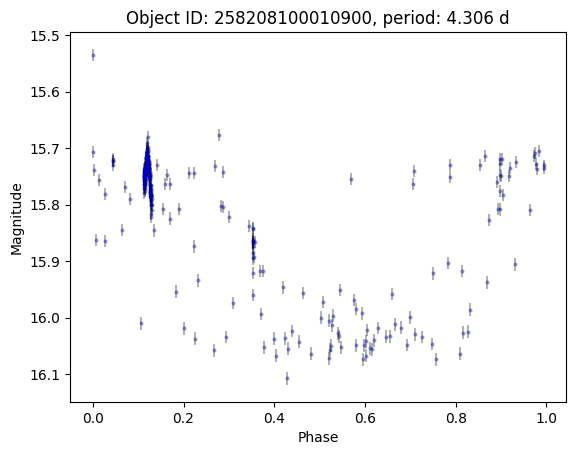

In [36]:
# Pick an interesting result by eye
interesting_idx = 1456145241786570789

import matplotlib.pyplot as plt

row = ztf_w_periods.loc[interesting_idx]
lc = row.timeseries

peak_mjd = lc["hmjd"][lc["mag"].idxmin()]
lc["phase"] = (lc["hmjd"] - peak_mjd) % row.period / row.period

plt.errorbar(
    lc["phase"],
    lc["mag"],
    lc["magerr"],
    alpha=0.3,
    ls="none",
    marker="o",
    markersize=2,
    markeredgecolor="blue",
    color="black",
)
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title(f"Object ID: {row.objectid}, period: {row.period:.3f} d")